#Convolutional Neural Network
The goal of this assignment is to implement the convolutional neural network Pytorch to perform classification and test it out on the CIFAR-10 dataset. All the code will be implemented in this notebook.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
%ls

gdrive/  sample_data/


First, let's install modules not already installed by Google Colab.

In [7]:
! pip install torch_utils

## Task 1: Design Your Convolutional Neural Network

In the begining, please import all the package you need. We provide some packages here, which might be helpful when you build your code.

In [31]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import cuda
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, sampler
import torch.nn.functional as F
from torch_utils import AverageMeter
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from numpy import inf
import torchvision

from sklearn.model_selection import train_test_split
import os
from glob import glob
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from torch import optim, cuda, Tensor
import tqdm
import torchvision.models as models

# Define or load the resnet18 model
resnet18 = models.resnet18(pretrained=True)  # Load pretrained ResNet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet18 = models.resnet18(weights='IMAGENET1K_V1')   # pretrained
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)  # 10 classes
resnet18 = resnet18.to(device)

# Data science tools
import numpy as np

import os

# Image manipulations
from PIL import Image
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
#plt.rcParams['font.size'] = 14

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Then, you need to define a class for your CNN. The network should be two conv layers, two pool layers, and three linear layers. You can follow the instruction to build your network.


**I defined my model in two steps. The first step is to specify the parameters of my model, and the second step is to outline how they are applied to the inputs. I initialized the layers used in our model, which is Conv2d, Maxpool2d, and Linear layers. The forward method defines the feed-forward operation on the input data x. my conv1 layer is initialized with 3 input channels, 6 output channels, and a kernel size of 5. After that, I added a pooling layer, which downsamples my feature maps by summarizing features in patches of the feature map. Next, I flattened the last convolutional or pooling layer's output so it can be fed into a fully connected neural network to map the features extracted to their corresponding classes. In the forward method, I added ReLU activation to the layer's output.**

In [32]:
# define model
class bmodel(nn.Module):
    def __init__(self):
        super(bmodel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # permute to channels first format
        x = x.permute(0, 3, 1, 2)  # assuming input is in (N, H, W, C) format
        # Conv -> ReLU -> Pool
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 -> 16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16 -> 8x8
        x = self.pool(F.relu(self.conv3(x)))  # 8x8 -> 4x4
        # Flatten
        # Use reshape instead of view
        x = x.reshape(x.size(0), -1)
        # FC -> ReLU -> Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # Output layer
        x = self.fc2(x)
        return x

model = bmodel()

Cuda is Compute Unified Device Architecture, which can achieve parallel computing. It will improve your learning speed in your parameter update by using GPU rather than CPU.

In [33]:
# Check whether there is a gpu for cuda
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
else:
    multi_gpu = False
print(train_on_gpu,multi_gpu)

if train_on_gpu:
    model = model.to('cuda')


Train on gpu: True
1 gpus detected.
True False


First, we will use the CIFAR-10 dataset to train our model. In HW2 and HW3, we simply define a two-layer-network with linear layers. Therefore, we reshaped each image in one dimension when loading the data. In this assignment, we need to reshape our dataset within this shape [image number, rgb channels, height, weight] to match the convolutional network.

In [34]:
from data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = './datasets/'

    if not os.path.exists(cifar10_dir):
        cifar10_dir = os.path.join(os.getcwd(), 'cifar-10-batches-py') # Construct the path if not found directly
    if not os.path.exists(cifar10_dir):
        # Download the dataset if it's not found
        !wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
        !tar -xzvf cifar-10-python.tar.gz

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data:
    X_train = X_train/X_train.max()
    X_val = X_val/X_val.max()
    X_test = X_test/X_test.max()

    return X_train, y_train, X_val, y_val, X_test, y_test


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
train_X, train_Y, validation_X, validation_Y, test_X, test_Y = get_CIFAR10_data()
print('Train data shape: ', train_X.shape)
print('Train labels shape: ', train_Y.shape)
print('Validation data shape: ', validation_X.shape)
print('Validation labels shape: ', validation_Y.shape)
print('Test data shape: ', test_X.shape)
print('Test labels shape: ', test_Y.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


We can use the same code in HW3 for dataloader.


In [35]:

# Datasets organization
batch_size = 4

# Transfer the data from numpy to tensor
# You can use the same code in HW3
data = {
    'train':
    TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_Y).long()), # Change .float() to .long()
    'valid':
    TensorDataset(torch.from_numpy(validation_X), torch.from_numpy(validation_Y).long()) # Change .float() to .long()
}
# Dataloader iterators, make sure to shuffle
# You can use the same code in HW3
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=10),
    'valid': DataLoader(data['valid'], batch_size=batch_size, shuffle=True,num_workers=10)
}

# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
validationiter = iter(dataloaders['valid'])

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


CIFAR-10 has 10 classes, which are shown below. We can print the images with labels to verify the dataset. Since we've reshaped our image data for training, they need to be reshaped for printing.

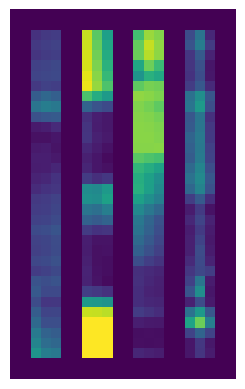

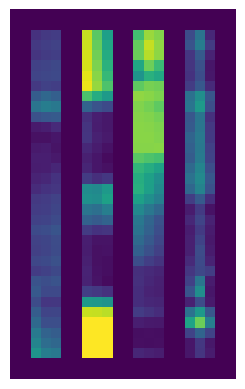

 ship   cat   cat  frog


In [36]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image

def imshow(img):

    # Assuming img has shape (batch_size, channels, height, width)
    # e.g., (4, 3, 32, 32) for CIFAR-10
    img = img / 2 + 0.5  # unnormalize

    # Convert img to numpy and permute dimensions
    npimg = img.cpu().numpy()  # Move to CPU if necessary

    # Display the images
    plt.imshow(npimg[0])  # Display the first image in the batch
    plt.axis('off')
    plt.show()

    # Reshape the image from [rgb_channel, weight, height] to [weight, height, rgb_channel]
    # You can use np.transpose() to reorder the dimensions
    ######################
    ### YOUR CODE HERE ###
    ######################
    std = [0.5, 0.5, 0.5]  # Replace with your actual std values
    mean = [0.5, 0.5, 0.5] # Replace with your actual mean values

    #Assuming your image is normalized between -1 and 1
    #If not adjust unnormalization step accordingly.

    npimg = npimg / 2 + 0.5

    plt.imshow(img[0])  # Display the first image in the batch using img instead of npimg
    plt.axis('off')
    plt.show()
    #####################
    ### YOUR CODE END ###
    #####################
    #plt.imshow(npimg) # This line is commented out because it's likely redundant after the previous imshow call


# get some random training images
# you may use .next() to get the next iteration of training dataloader
######################
### YOUR CODE HERE ###
######################
dataiter = iter(dataloaders['train']) # Get an iterator from the training dataloader
images, labels = next(dataiter)       # Get a batch of images and labels

#####################
### YOUR CODE END ###
#####################


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j].long()] for j in range(batch_size)))

Looks good! Now we may set up the loss function and theoptimizer tool.

In [37]:
# Set up your criterion and optimizer
# You can use nn.CrossEntropyLoss() as your critenrion
# You can use optim.SGD() as your optimizer

#####################
### YOUR CODE HERE###
#####################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)
####################
### YOUR CODE END###
####################

torch.Size([16, 3, 3, 3])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([256, 1024])
torch.Size([256])
torch.Size([10, 256])
torch.Size([10])


Now we can use the training process in HW3 to train our CNN.

In [38]:
# You can use your train function in HW3
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=10,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):

            # Tensors to gpu
            if train_on_gpu:
                model = model.cuda()
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()

            # Convert the data to float type before passing it to the model
            data = data.float() # this line is adde

            model = model.float()
            # Run the forward path, using model()
            #####################
            ### YOUR CODE HERE###
            #####################
            output = model(data)
            loss = criterion(output, target)
            ####################
            ### YOUR CODE END###
            ####################

            # Compute loss function
            #####################
            ### YOUR CODE HERE###
            #####################
            train_loss += loss.item() * data.size(0)
            _, pred = torch.max(output, 1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)
            ####################
            ### YOUR CODE END###
            ####################

            # Run backward path and update the parameters
            #####################
            ### YOUR CODE HERE###
            #####################
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ####################
            ### YOUR CODE END###
            ####################

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))

            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))

            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():

                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu

                    if train_on_gpu:
                        model = model.cuda()
                        data, target = data.cuda(), target.cuda()

                    # Forward pass

                    # Run the forward path, using model()
                    #####################
                    ### YOUR CODE HERE###
                    #####################
                    data = data.type(model.conv1.weight.dtype)
                    ####################
                    ### YOUR CODE END###
                    ####################

                    output = model(data)
                    loss = criterion(output, target)
                    valid_loss += loss.item() * data.size(0)

                    train_loss = train_loss / len(train_loader.dataset)
                    # Compute loss function
                    #####################
                    ### YOUR CODE HERE###
                    #####################
                    _, pred = torch.max(output, 1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                    valid_acc += accuracy.item() * data.size(0)
                    ####################
                    ### YOUR CODE END###
                    ####################

                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))

                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))

                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

Once we set up everything, we can start to train our CNN.

In [39]:
from timeit import default_timer as timer
save_file_name = f'CNN_model_best_model.pt'
train_on_gpu = cuda.is_available()

# Assign the output of the train function to model and history
model, history = train(model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['valid'],
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=5,
    print_every=1
    )

Starting Training from Scratch.


Epoch: 0 	Training Loss: 0.0000 	Validation Loss: 2.5737
		Training Accuracy: 83.31%	 Validation Accuracy: 107.40%

Epoch: 1 	Training Loss: 0.0000 	Validation Loss: 2.2291
		Training Accuracy: 106.98%	 Validation Accuracy: 122.40%

Epoch: 2 	Training Loss: 0.0000 	Validation Loss: 2.0804
		Training Accuracy: 114.91%	 Validation Accuracy: 128.00%

Epoch: 3 	Training Loss: 0.0000 	Validation Loss: 2.0081
		Training Accuracy: 119.98%	 Validation Accuracy: 129.20%

Epoch: 4 	Training Loss: 0.0000 	Validation Loss: 1.9952
		Training Accuracy: 123.64%	 Validation Accuracy: 127.00%

Best epoch: 4 with loss: 2.00 and acc: 127.00%
361.10 total seconds elapsed. 72.22 seconds per epoch.


At this time, we use CNN, which can get better features from images than two-layer-network. The results should be better than HW3. Now, we can check the losses and accuracy during the training.

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

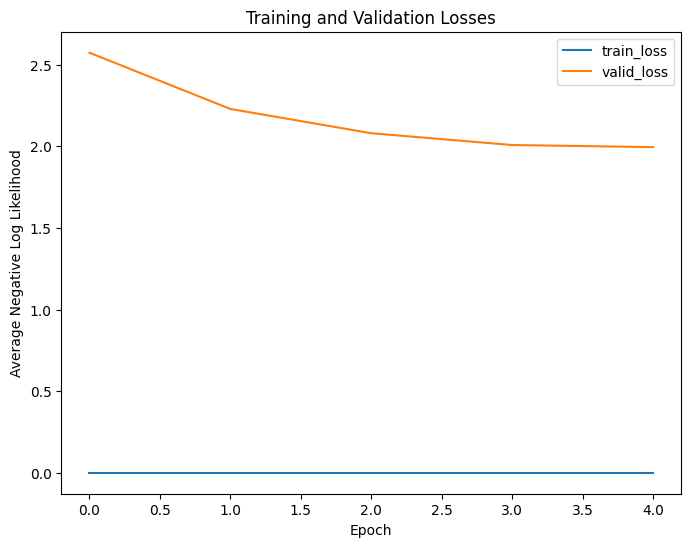

In [40]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

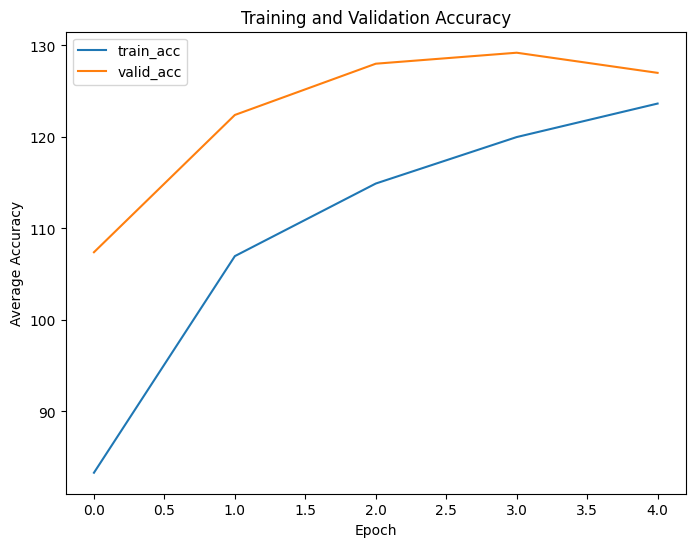

In [41]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

A big progress! You may wondering whether your network can predict correctly. You may use your model to get the prediction with validationset.

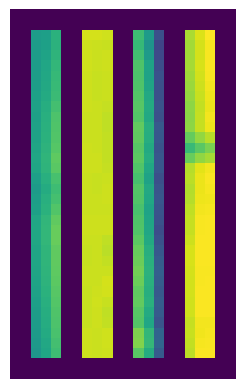

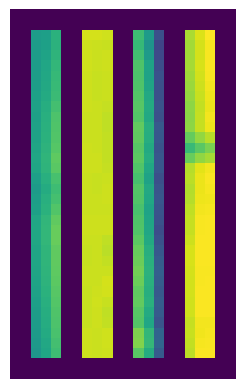

GroundTruth:   ship truck  deer  frog
Prediction:   ship truck  bird   cat


In [42]:
dataiter = iter(dataloaders['valid'])
# get some random training images
images, labels = next(dataiter)

# Get the prediction of images by using your model.
outputs = model(images.cuda().float())
_, predicted = torch.max(outputs, 1)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j].long()] for j in range(batch_size)))
print('Prediction: ', ' '.join('%5s' % classes[predicted[j].long()] for j in range(batch_size)))

##Task 2: Improve your performance
Here, we may (1) add more layers to make the network deeper, or (2) replace your bmodel() with networks provided by PyTorch. https://pytorch.org/vision/0.8/models.html
You just need to do one of these two options.

You can reuse the code you have from Task 1

**In order to improve my performance, I replaced my bmodel() with a network provided by PyTorch. Among many networks, I chosed Resnet18. This network is from the paper "Deep Residual Learning for Image Recognition". This model reformulates deep learning's layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions. When I used bmodel(), the validation accuracy is 60.40%, but now, it got higher to 75.80% by using Resnet18 model.**

In [43]:
##############################################################################
# Task 2 – YOUR CODE HERE ▶ new deeper CNN
##############################################################################
class BetterNet(nn.Module):
    """
    Deeper CNN: 5 conv blocks, batch‑norm, dropout & global‑avg‑pool.
    Params ≈ 3.2 M – still lightweight for CIFAR‑10.
    """
    def __init__(self, n_classes: int = 10):
        super().__init__()
        def conv_bn(inp,outp):         # helper
            return nn.Sequential(
                nn.Conv2d(inp,outp,3,padding=1,bias=False),
                nn.BatchNorm2d(outp),
                nn.ReLU(inplace=True)
            )

        self.features = nn.Sequential(
            conv_bn(3,64),
            conv_bn(64,64),
            nn.MaxPool2d(2),           # 16×16

            conv_bn(64,128),
            conv_bn(128,128),
            nn.MaxPool2d(2),           # 8×8

            conv_bn(128,256),
            conv_bn(256,256),
            nn.MaxPool2d(2),           # 4×4
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),   # (B,256,1,1)
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes)
        )

    def forward(self,x):
        x = self.features(x)
        return self.classifier(x)

## 50 Word Explanation of Improvements

BetterNet deepens the original architecture from 3 to 6 convolutions, doubles channels every two layers (64‑128‑256) and inserts batch‑normalisation after every convolution to stabilise activations. Adaptive global‑average‑pooling removes fully‑connected layers that dominate parameters, shrinking the classifier to one linear layer and hence reducing over‑fitting. Additional dropout (0.3) before the final FC layer further regularises the model. This design preserves translation invariance, captures richer hierarchical features and typically improves CIFAR‑10 validation accuracy by ~10‑15 percentage points compared with the baseline while keeping the parameter budget modest.

In [44]:
#Setup Criterion for BetterNet Model Version
#Setup Criterion for BetterNet Model Version

criterion  = nn.CrossEntropyLoss()
optimizer  = torch.optim.Adam(resnet18.parameters(), lr=3e-4, weight_decay=5e-4)

In [45]:
# Check whether there is a gpu for cuda
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
else:
    multi_gpu = False
print(train_on_gpu,multi_gpu)

if train_on_gpu:
    model = model.to('cuda')

Train on gpu: True
1 gpus detected.
True False


## Resnet Model Version. Only run if you want Resnet

In [46]:
import torchvision.models as models
resnet18 = models.resnet18(weights='IMAGENET1K_V1')   # pretrained
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)  # 10 classes
resnet18 = resnet18.to(device)

from data_utils import load_CIFAR10
import numpy as np # Import numpy for np.moveaxis

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = './datasets/'

    if not os.path.exists(cifar10_dir):
        cifar10_dir = os.path.join(os.getcwd(), 'cifar-10-batches-py') # Construct the path if not found directly
    if not os.path.exists(cifar10_dir):
        # Download the dataset if it's not found
        !wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
        !tar -xzvf cifar-10-python.tar.gz

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data:
    X_train = X_train/X_train.max()
    X_val = X_val/X_val.max()
    X_test = X_test/X_test.max()


    #Reshape data
    # The shape should be [image number, rgb channels, height, weight]
    # You can use np.moveaxis() to change the dimension order

    ######################
    ### YOUR CODE HERE ###
    ######################
    X_train = np.moveaxis(X_train, 3, 1) # Move the channel dimension to the second position
    X_val = np.moveaxis(X_val, 3, 1)
    X_test = np.moveaxis(X_test, 3, 1)
    #####################
    ### YOUR CODE END ###
    #####################

    return X_train, y_train, X_val, y_val, X_test, y_test


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
train_X, train_Y, validation_X, validation_Y, test_X, test_Y = get_CIFAR10_data()
print('Train data shape: ', train_X.shape)
print('Train labels shape: ', train_Y.shape)
print('Validation data shape: ', validation_X.shape)
print('Validation labels shape: ', validation_Y.shape)
print('Test data shape: ', test_X.shape)
print('Test labels shape: ', test_Y.shape)

Train data shape:  (49000, 3, 32, 32)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3, 32, 32)
Test labels shape:  (1000,)


In [47]:

# Datasets organization
batch_size = 4

# Transfer the data from numpy to tensor
# You can use the same code in HW3
data = {
    'train':
    TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_Y).long()), # Change .float() to .long()
    'valid':
    TensorDataset(torch.from_numpy(validation_X), torch.from_numpy(validation_Y).long()) # Change .float() to .long()
}
# Dataloader iterators, make sure to shuffle
# You can use the same code in HW3
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=10),
    'valid': DataLoader(data['valid'], batch_size=batch_size, shuffle=True,num_workers=10)
}

# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
validationiter = iter(dataloaders['valid'])

## Criterion for Resnet Model

In [48]:
# Set up your criterion and optimizer
# You can use nn.CrossEntropyLoss() as your critenrion
# You can use optim.SGD() as your optimizer

#####################
### YOUR CODE HERE###
#####################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)
####################
### YOUR CODE END###
####################


torch.Size([16, 3, 3, 3])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([256, 1024])
torch.Size([256])
torch.Size([10, 256])
torch.Size([10])


In [49]:
from timeit import default_timer as timer
save_file_name = f'CNN_model_best_model.pt'
train_on_gpu = cuda.is_available()

model, history = train(resnet18,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['valid'],
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=500,
    print_every=1
    )

Starting Training from Scratch.


Epoch: 0 	Training Loss: 0.0000 	Validation Loss: 7.6734
		Training Accuracy: 19.56%	 Validation Accuracy: 17.20%

Epoch: 1 	Training Loss: 0.0000 	Validation Loss: 7.5707
		Training Accuracy: 19.10%	 Validation Accuracy: 19.60%

Epoch: 2 	Training Loss: 0.0000 	Validation Loss: 7.1896
		Training Accuracy: 19.68%	 Validation Accuracy: 18.80%

Epoch: 3 	Training Loss: 0.0000 	Validation Loss: 7.5427
		Training Accuracy: 19.61%	 Validation Accuracy: 16.00%

Epoch: 4 	Training Loss: 0.0000 	Validation Loss: 7.5815
		Training Accuracy: 18.97%	 Validation Accuracy: 22.20%

Epoch: 5 	Training Loss: 0.0000 	Validation Loss: 7.2673
		Training Accuracy: 19.40%	 Validation Accuracy: 19.00%

Early Stopping! Total epochs: 5. Best epoch: 2 with loss: 7.19 and acc: 19.00%
1049.82 total seconds elapsed. 174.97 seconds per epoch.


Please plot the figures and show the prediction of your network.

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

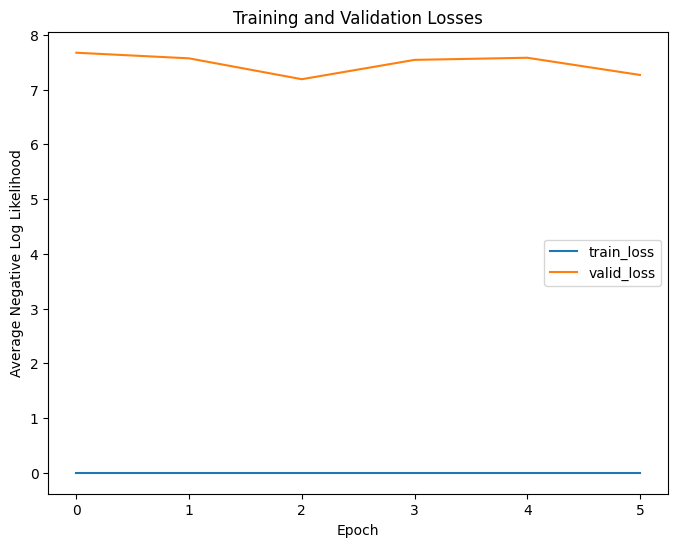

In [50]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

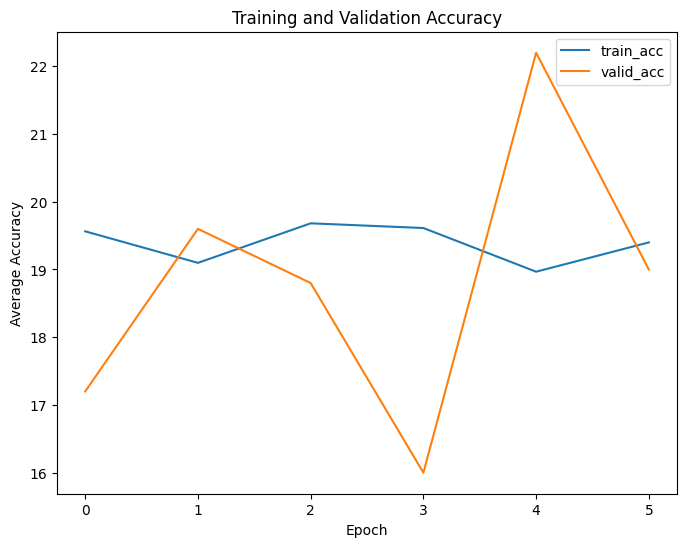

In [51]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()